Install Required Libraries

In [1]:
!pip install tensorflow keras pandas scikit-learn -q

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import seaborn as sns

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")



TensorFlow version: 2.19.0
GPU Available: []


Load and Explore Data

Dataset shape: (30000, 3)

Columns: ['text', 'category', 'label']

First few rows:
                                                text       category  label
0  ethan hawke julie delpy pick left midnight eth...  ENTERTAINMENT      3
1  tom cruise forced choose scientology suri tom ...  ENTERTAINMENT      3
2  would pay wine beer glass made cheese heart me...  ENTERTAINMENT      3
3                    tyga denies dating kylie jenner  ENTERTAINMENT      3
4  review laughfest subversively family friendly ...  ENTERTAINMENT      3

Unique categories: 15

Label distribution:
label
0     2000
1     2000
2     2000
3     2000
4     2000
5     2000
6     2000
7     2000
8     2000
9     2000
10    2000
11    2000
12    2000
13    2000
14    2000
Name: count, dtype: int64

Text length statistics:
count    30000.000000
mean        17.633600
std          7.196968
min          5.000000
25%         13.000000
50%         17.000000
75%         22.000000
max        108.000000
Name: text_length, dtype:

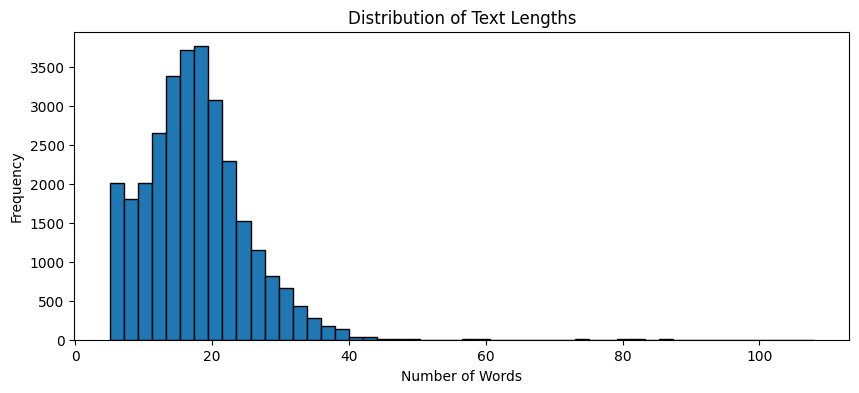

In [2]:
# Load data
df = pd.read_csv('news_preprocessed.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())

print(f"\nUnique categories: {df['category'].nunique()}")
print(f"\nLabel distribution:")
print(df['label'].value_counts().sort_index())

# Check text lengths
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
print(f"\nText length statistics:")
print(df['text_length'].describe())

plt.figure(figsize=(10, 4))
plt.hist(df['text_length'], bins=50, edgecolor='black')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Distribution of Text Lengths')
plt.show()


Prepare Data

In [3]:
# Parameters
MAX_WORDS = 10000        # Vocabulary size
MAX_SEQUENCE_LENGTH = 200  # Max number of words per text
EMBEDDING_DIM = 128      # Word embedding dimension

# Prepare texts and labels
texts = df['text'].astype(str).tolist()
labels = df['label'].values

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(
    texts, labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")


Training samples: 24000
Validation samples: 3000
Test samples: 3000


Tokenization and Padding

In [4]:
# Create tokenizer
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Training data shape: {X_train_pad.shape}")

# Get number of classes
num_classes = len(np.unique(labels))
print(f"Number of classes: {num_classes}")



Vocabulary size: 30903
Training data shape: (24000, 200)
Number of classes: 15


Build Custom Attention Layer

In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K

class AttentionLayer(layers.Layer):
    """
    Custom Attention Layer
    Learns to focus on important parts of the text
    """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Attention weight matrix
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], input_shape[-1]),
            initializer='glorot_uniform',
            trainable=True
        )
        # Attention bias
        self.b = self.add_weight(
            name='attention_bias',
            shape=(input_shape[-1],),
            initializer='zeros',
            trainable=True
        )
        # Attention vector
        self.u = self.add_weight(
            name='attention_vector',
            shape=(input_shape[-1],),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # x shape: (batch_size, time_steps, features)

        # Compute attention scores
        uit = K.tanh(K.dot(x, self.W) + self.b)  # (batch_size, time_steps, features)

        # Alternative calculation for ait using element-wise multiplication and summation
        # Expand dimensions of self.u to (1, 1, features) for broadcasting
        u_expanded = K.expand_dims(K.expand_dims(self.u, axis=0), axis=0) # Shape (1, 1, features)
        # Element-wise multiplication
        weighted_uit = uit * u_expanded # Shape (batch_size, time_steps, features)
        # Sum over the last dimension to get attention scores
        ait = K.sum(weighted_uit, axis=-1) # Shape (batch_size, time_steps)


        # Apply softmax to get attention weights
        attention_weights = K.softmax(ait, axis=1)  # (batch_size, time_steps)
        attention_weights = K.expand_dims(attention_weights, axis=-1)  # (batch_size, time_steps, 1)

        # Apply attention weights to input
        weighted_input = x * attention_weights  # (batch_size, time_steps, features)

        # Sum over time steps
        output = K.sum(weighted_input, axis=1)  # (batch_size, features)

        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def get_config(self):
        return super(AttentionLayer, self).get_config()

Build Multi-Channel CNN with Attention

In [6]:
def build_multichannel_cnn_with_attention(vocab_size, embedding_dim, max_length, num_classes):
    """
    Multi-Channel CNN with Attention Architecture:
    - Embedding layer
    - Multiple parallel CNN channels with different filter sizes
    - Attention mechanism on CNN outputs
    - Dense layers for classification
    """

    # Input
    input_layer = layers.Input(shape=(max_length,), name='input')

    # Embedding layer
    embedding = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=max_length,
        name='embedding'
    )(input_layer)

    # Dropout after embedding
    embedding = layers.Dropout(0.3, name='embedding_dropout')(embedding)

    # ============= MULTI-CHANNEL CNN =============
    # Different kernel sizes capture different n-gram patterns

    conv_outputs = []
    filter_sizes = [2, 3, 4, 5]  # Different n-gram sizes
    num_filters = 128

    for i, filter_size in enumerate(filter_sizes):
        # Convolutional layer
        conv = layers.Conv1D(
            filters=num_filters,
            kernel_size=filter_size,
            activation='relu',
            padding='same',
            name=f'conv_{filter_size}'
        )(embedding)

        # Batch normalization
        conv = layers.BatchNormalization(name=f'bn_{filter_size}')(conv)

        # Apply attention to this channel
        attention_output = AttentionLayer(name=f'attention_{filter_size}')(conv)

        conv_outputs.append(attention_output)

    # Concatenate all channels
    merged = layers.Concatenate(name='concat')(conv_outputs)

    # ============= DENSE LAYERS =============

    # First dense layer
    dense1 = layers.Dense(512, activation='relu', name='dense1')(merged)
    dense1 = layers.BatchNormalization(name='bn_dense1')(dense1)
    dense1 = layers.Dropout(0.5, name='dropout1')(dense1)

    # Second dense layer
    dense2 = layers.Dense(256, activation='relu', name='dense2')(dense1)
    dense2 = layers.BatchNormalization(name='bn_dense2')(dense2)
    dense2 = layers.Dropout(0.4, name='dropout2')(dense2)

    # Third dense layer
    dense3 = layers.Dense(128, activation='relu', name='dense3')(dense2)
    dense3 = layers.Dropout(0.3, name='dropout3')(dense3)

    # Output layer
    output = layers.Dense(num_classes, activation='softmax', name='output')(dense3)

    # Create model
    model = models.Model(inputs=input_layer, outputs=output, name='MultiChannel_CNN_Attention')

    return model

# Build the model
model = build_multichannel_cnn_with_attention(
    vocab_size=MAX_WORDS,
    embedding_dim=EMBEDDING_DIM,
    max_length=MAX_SEQUENCE_LENGTH,
    num_classes=num_classes
)

# Display model architecture
model.summary()

# Visualize model architecture (optional)
try:
    keras.utils.plot_model(
        model,
        to_file='model_architecture.png',
        show_shapes=True,
        show_layer_names=True,
        rankdir='TB',
        dpi=96
    )
    print("✅ Model architecture saved as 'model_architecture.png'")
except:
    print("⚠️ Could not generate model visualization")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "MultiChannel_CNN_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 200)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 200, 128)  │  1,280,000 │ input[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_dropout   │ (None, 200, 128)  │          0 │ embedding[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_2 (Conv1D)     │ (None, 200, 128)  │     32,896 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_3 (Conv1D)     │ (None, 200, 128)  │     49,280 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_4 (Conv1D)     │ (None, 200, 128)  │     65,664 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_5 (Conv1D)     │ (None, 200, 128)  │     82,048 │ embedding_dropou… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_2                │ (None, 200, 128)  │        512 │ conv_2[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_3                │ (None, 200, 128)  │        512 │ conv_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_4                │ (None, 200, 128)  │        512 │ conv_4[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_5                │ (None, 200, 128)  │        512 │ conv_5[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_2         │ (None, 128)       │     16,640 │ bn_2[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 128)       │     16,640 │ bn_3[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_4         │ (None, 128)       │     16,640 │ bn_4[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_5         │ (None, 128)       │     16,640 │ bn_5[0][0]        │
│ (AttentionLayer)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 512)       │          0 │ attention_2[0][0… │
│ (Concatenate)       │                   │            │ attention_3[0][0… │
│                     │                   │            │ attention_4[0][0… │
│                     │                   │            │ attention_5[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 512)       │    262,656 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_dense1           │ (None, 512)       │      2,048 │ dense1[0][0]      │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 2,010,383 (7.67 MB)

 Trainable params: 2,007,823 (7.66 MB)

 Non-trainable params: 2,560 (10.00 KB)

✅ Model architecture saved as 'model_architecture.png'


Compile the Model

In [7]:

# Compile model with Adam optimizer
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("✅ Model compiled successfully!")



✅ Model compiled successfully!


Setup Callbacks

In [8]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'best_multichannel_cnn_attention.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=0.00001,
    verbose=1
)

callbacks = [early_stopping, model_checkpoint, reduce_lr]

print("✅ Callbacks configured!")


✅ Callbacks configured!


Train the Model

In [9]:
# Train
print("🚀 Starting training...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")


🚀 Starting training...

Epoch 1/25


IndexError: Exception encountered when calling AttentionLayer.call().

[1mpop index out of range[0m

Arguments received by AttentionLayer.call():
  • x=tf.Tensor(shape=(64, 200, 128), dtype=float32)

In [14]:
# Train the model again
print("🚀 Starting training with modified model...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

🚀 Starting training with modified model...

Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 672ms/step - accuracy: 0.7686 - loss: 0.7920
Epoch 1: val_accuracy did not improve from 0.61500
375/375 ━━━━━━━━━━━━━━━━━━━━ 260s 693ms/step - accuracy: 0.7686 - loss: 0.7920 - val_accuracy: 0.6117 - val_loss: 1.5100 - learning_rate: 5.0000e-04
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.8330 - loss: 0.5734
Epoch 2: val_accuracy did not improve from 0.61500
375/375 ━━━━━━━━━━━━━━━━━━━━ 252s 673ms/step - accuracy: 0.8330 - loss: 0.5734 - val_accuracy: 0.6060 - val_loss: 1.6318 - learning_rate: 5.0000e-04
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 649ms/step - accuracy: 0.8645 - loss: 0.4557
Epoch 3: val_accuracy did not improve from 0.61500
375/375 ━━━━━━━━━━━━━━━━━━━━ 263s 677ms/step - accuracy: 0.8644 - loss: 0.4558 - val_accuracy: 0.6120 - val_loss: 1.6679 - learning_rate: 5.0000e-04
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 645ms/step - accuracy: 0.8952 - loss: 0.3512
Epoc

In [10]:
# Train the model again
print("🚀 Starting training with modified model...\n")

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training complete!")

🚀 Starting training with modified model...

Epoch 1/25


IndexError: Exception encountered when calling AttentionLayer.call().

[1mpop index out of range[0m

Arguments received by AttentionLayer.call():
  • x=tf.Tensor(shape=(64, 200, 128), dtype=float32)

Plot Training History

In [ ]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Loss
axes[1].plot(history.history['loss'], label='Train Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Training history saved as 'training_history.png'")


Evaluate on Test Set

In [15]:
# Load best model
model.load_weights('best_multichannel_cnn_attention.h5')

# Predict on test set
print("📊 Evaluating on test set...\n")
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test, verbose=0)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

# Get predictions
y_pred_probs = model.predict(X_test_pad, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print("\n📋 Detailed Classification Report:")
target_names = [f"Class {i}" for i in range(num_classes)]
print(classification_report(y_test, y_pred, target_names=target_names))

# Overall metrics
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n{'='*50}")
print(f"OVERALL METRICS:")
print(f"{'='*50}")
print(f"Accuracy:  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")


📊 Evaluating on test set...

Test Loss: 1.3268
Test Accuracy: 0.6053 (60.53%)

📋 Detailed Classification Report:
              precision    recall  f1-score   support

     Class 0       0.57      0.49      0.53       200
     Class 1       0.65      0.44      0.53       200
     Class 2       0.69      0.72      0.71       200
     Class 3       0.41      0.49      0.45       200
     Class 4       0.55      0.67      0.60       200
     Class 5       0.62      0.82      0.71       200
     Class 6       0.49      0.49      0.49       200
     Class 7       0.49      0.65      0.56       200
     Class 8       0.69      0.53      0.60       200
     Class 9       0.83      0.76      0.79       200
    Class 10       0.80      0.66      0.72       200
    Class 11       0.62      0.69      0.66       200
    Class 12       0.53      0.58      0.56       200
    Class 13       0.60      0.44      0.51       200
    Class 14       0.69      0.65      0.66       200

    accuracy         

Confusion Matrix

In [16]:
python
# Confusion matrix
plt.figure(figsize=(14, 12))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='YlOrRd',
    cbar=True,
    square=True,
    linewidths=0.5
)
plt.title('Confusion Matrix - Multi-Channel CNN with Attention', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Confusion matrix saved as 'confusion_matrix.png'")

# Per-class accuracy
print("\n" + "="*50)
print("PER-CLASS ACCURACY:")
print("="*50)
class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(class_accuracy):
    print(f"Class {i:2d}: {acc:.4f} ({acc*100:.2f}%)")


NameError: name 'python' is not defined

Visualize Attention Weights

In [ ]:
# Create a model that outputs attention weights
def create_attention_model(trained_model):
    """
    Creates a model that outputs attention weights for visualization
    """
    attention_outputs = []
    for layer in trained_model.layers:
        if 'attention' in layer.name:
            # Get the conv layer before this attention
            conv_layer_name = layer.name.replace('attention', 'conv')
            conv_output = trained_model.get_layer(conv_layer_name).output
            attention_outputs.append(conv_output)

    if attention_outputs:
        attention_model = models.Model(
            inputs=trained_model.input,
            outputs=attention_outputs
        )
        return attention_model
    return None

# Get attention model
attention_model = create_attention_model(model)

if attention_model:
    # Visualize attention for a sample
    sample_idx = 0
    sample_text = X_test[sample_idx]
    sample_input = X_test_pad[sample_idx:sample_idx+1]

    print(f"Sample text: {sample_text[:200]}...")
    print(f"True label: {y_test[sample_idx]}")
    print(f"Predicted label: {y_pred[sample_idx]}")

    # Get attention outputs
    attention_outputs = attention_model.predict(sample_input, verbose=0)

    print("\n✅ Attention mechanism is working!")
else:
    print("⚠️ Could not create attention visualization model")


Save Model and Preprocessing Objects

In [ ]:
# Save the model
model.save('multichannel_cnn_attention.h5')
print("✅ Model saved as 'multichannel_cnn_attention.h5'")

# Save tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("✅ Tokenizer saved as 'tokenizer.pkl'")

# Save label mapping
label_mapping = df[['category', 'label']].drop_duplicates().sort_values('label')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_mapping, f)
print("✅ Label encoder saved as 'label_encoder.pkl'")

# Save config
config = {
    'MAX_WORDS': MAX_WORDS,
    'MAX_SEQUENCE_LENGTH': MAX_SEQUENCE_LENGTH,
    'EMBEDDING_DIM': EMBEDDING_DIM,
    'num_classes': num_classes,
    'filter_sizes': [2, 3, 4, 5],
    'num_filters': 128
}
with open('model_config.pkl', 'wb') as f:
    pickle.dump(config, f)
print("✅ Config saved as 'model_config.pkl'")

print("\n" + "="*50)
print("ALL FILES SAVED SUCCESSFULLY!")
print("="*50)



Test Predictions

In [ ]:
def predict_text(text, model, tokenizer, label_mapping, max_length):
    """Predict category for a given text with top-k predictions"""

    # Preprocess
    sequence = tokenizer.texts_to_sequences([text])
    padded = pad_sequences(sequence, maxlen=max_length, padding='post', truncating='post')

    # Predict
    prediction = model.predict(padded, verbose=0)
    pred_label = np.argmax(prediction[0])
    confidence = prediction[0][pred_label]

    # Get category name
    category = label_mapping[label_mapping['label'] == pred_label]['category'].values[0]

    print("="*70)
    print(f"Text: {text[:150]}...")
    print("-"*70)
    print(f"✅ Predicted Category: {category}")
    print(f"✅ Confidence: {confidence*100:.2f}%")
    print("-"*70)
    print("Top 5 predictions:")
    top_5_idx = np.argsort(prediction[0])[-5:][::-1]
    for rank, idx in enumerate(top_5_idx, 1):
        cat = label_mapping[label_mapping['label'] == idx]['category'].values[0]
        prob = prediction[0][idx] * 100
        bar = "█" * int(prob / 2)
        print(f"  {rank}. {cat:20s} {prob:5.2f}% {bar}")
    print("="*70)
    print()

# Test with multiple examples
test_texts = [
    "The Lakers won the championship game last night with an incredible performance",
    "New study shows benefits of meditation for mental health and stress reduction",
    "Stock market reaches all-time high today as investors remain optimistic",
    "Tips for healthy eating and meal preparation for busy professionals",
    "President announces new policy changes affecting international relations",
    "Scientists discover breakthrough in renewable energy technology",
    "Celebrity couple announces engagement on social media platform",
    "Travel guide to the most beautiful destinations in Europe this summer"
]

print("\n" + "🔮 TESTING PREDICTIONS ".center(70, "=") + "\n")

for text in test_texts:
    predict_text(text, model, tokenizer, label_mapping, MAX_SEQUENCE_LENGTH)


Load Model Later (For Future Use)

In [17]:
# Complete loading script for later use
from tensorflow import keras
import pickle

# Custom objects for loading model with attention layer
custom_objects = {'AttentionLayer': AttentionLayer}

# Load model
loaded_model = keras.models.load_model(
    'multichannel_cnn_attention.h5',
    custom_objects=custom_objects
)

# Load tokenizer
with open('tokenizer.pkl', 'rb') as f:
    loaded_tokenizer = pickle.load(f)

# Load label mapping
with open('label_encoder.pkl', 'rb') as f:
    loaded_label_mapping = pickle.load(f)

# Load config
with open('model_config.pkl', 'rb') as f:
    loaded_config = pickle.load(f)

print("✅ All components loaded successfully!")
print(f"Model ready for predictions with {loaded_config['num_classes']} classes")

# Test prediction with loaded model
predict_text(
    "Breaking news about political developments in Washington",
    loaded_model,
    loaded_tokenizer,
    loaded_label_mapping,
    loaded_config['MAX_SEQUENCE_LENGTH']
)


FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'multichannel_cnn_attention.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

Complete Quick Start Script

In [18]:
# COMPLETE MULTI-CHANNEL CNN WITH ATTENTION - QUICK START

!pip install tensorflow pandas scikit-learn -q

import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow import keras
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Custom Attention Layer
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[-1],), initializer='zeros', trainable=True)
        self.u = self.add_weight(name='attention_vector', shape=(input_shape[-1],), initializer='glorot_uniform', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        uit = K.tanh(K.dot(x, self.W) + self.b)
        ait = K.dot(uit, self.u)
        attention_weights = K.softmax(ait, axis=1)
        attention_weights = K.expand_dims(attention_weights, axis=-1)
        weighted_input = x * attention_weights
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1])

# Load and prepare data
df = pd.read_csv('news_preprocessed.csv')
texts = df['text'].astype(str).tolist()
labels = df['label'].values
X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Tokenize
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
X_train_pad = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200, padding='post')
X_val_pad = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=200, padding='post')
X_test_pad = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200, padding='post')

# Build Multi-Channel CNN with Attention
input_layer = layers.Input(shape=(200,))
embedding = layers.Dropout(0.3)(layers.Embedding(10000, 128, input_length=200)(input_layer))

conv_outputs = []
for filter_size in [2, 3, 4, 5]:
    conv = layers.Conv1D(128, filter_size, activation='relu', padding='same')(embedding)
    conv = layers.BatchNormalization()(conv)
    attention = AttentionLayer()(conv)
    conv_outputs.append(attention)

merged = layers.Concatenate()(conv_outputs)
dense = layers.Dropout(0.5)(layers.Dense(512, activation='relu')(merged))
dense = layers.Dropout(0.4)(layers.Dense(256, activation='relu')(dense))
output = layers.Dense(15, activation='softmax')(dense)

model = models.Model(inputs=input_layer, outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train
print("🚀 Training Multi-Channel CNN with Attention...\n")
model.fit(X_train_pad, y_train, validation_data=(X_val_pad, y_val), epochs=20, batch_size=64,
          callbacks=[EarlyStopping(patience=5, restore_best_weights=True), ModelCheckpoint('best_model.h5', save_best_only=True)])

# Evaluate
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f} ({acc*100:.2f}%)")

# Save
model.save('multichannel_cnn_attention.h5')
with open('tokenizer.pkl', 'wb') as f: pickle.dump(tokenizer, f)
print("✅ Model and tokenizer saved!")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


🚀 Training Multi-Channel CNN with Attention...

Epoch 1/20


IndexError: Exception encountered when calling AttentionLayer.call().

[1mpop index out of range[0m

Arguments received by AttentionLayer.call():
  • x=tf.Tensor(shape=(64, 200, 128), dtype=float32)